In [1]:
!pip install scipy
!pip install h5py
!pip install mat73

In [2]:
import h5py
import numpy as np
import pathlib
from scipy.io import loadmat
import mat73

In [3]:
def load_iq(iq_file: str, input_var_name="") -> np.ndarray:
    ext = pathlib.Path(iq_file).suffix
    if ext == ".mat":
        # Load IQ.
        try:
            iq = loadmat(iq_file, squeeze_me=True)[input_var_name]
        except NotImplementedError:
            iq = mat73.loadmat(iq_file)[input_var_name]  # If IQ is saved in 7.3.
    elif ext == ".npy":
        iq = np.load(iq_file)

    elif ext == ".npz":
        iq = np.load(iq_file)[input_var_name]

    else:
        raise NotImplementedError(
            f"Loading iq with extension {ext} is not implemented."
        )
    return iq

In [5]:
filepath = 'mat/IQ001.mat'
var_name = 'IQ'
data = load_iq(filepath,var_name)

In [6]:
print(data.shape)
# print(data)

(68, 65, 70, 200)


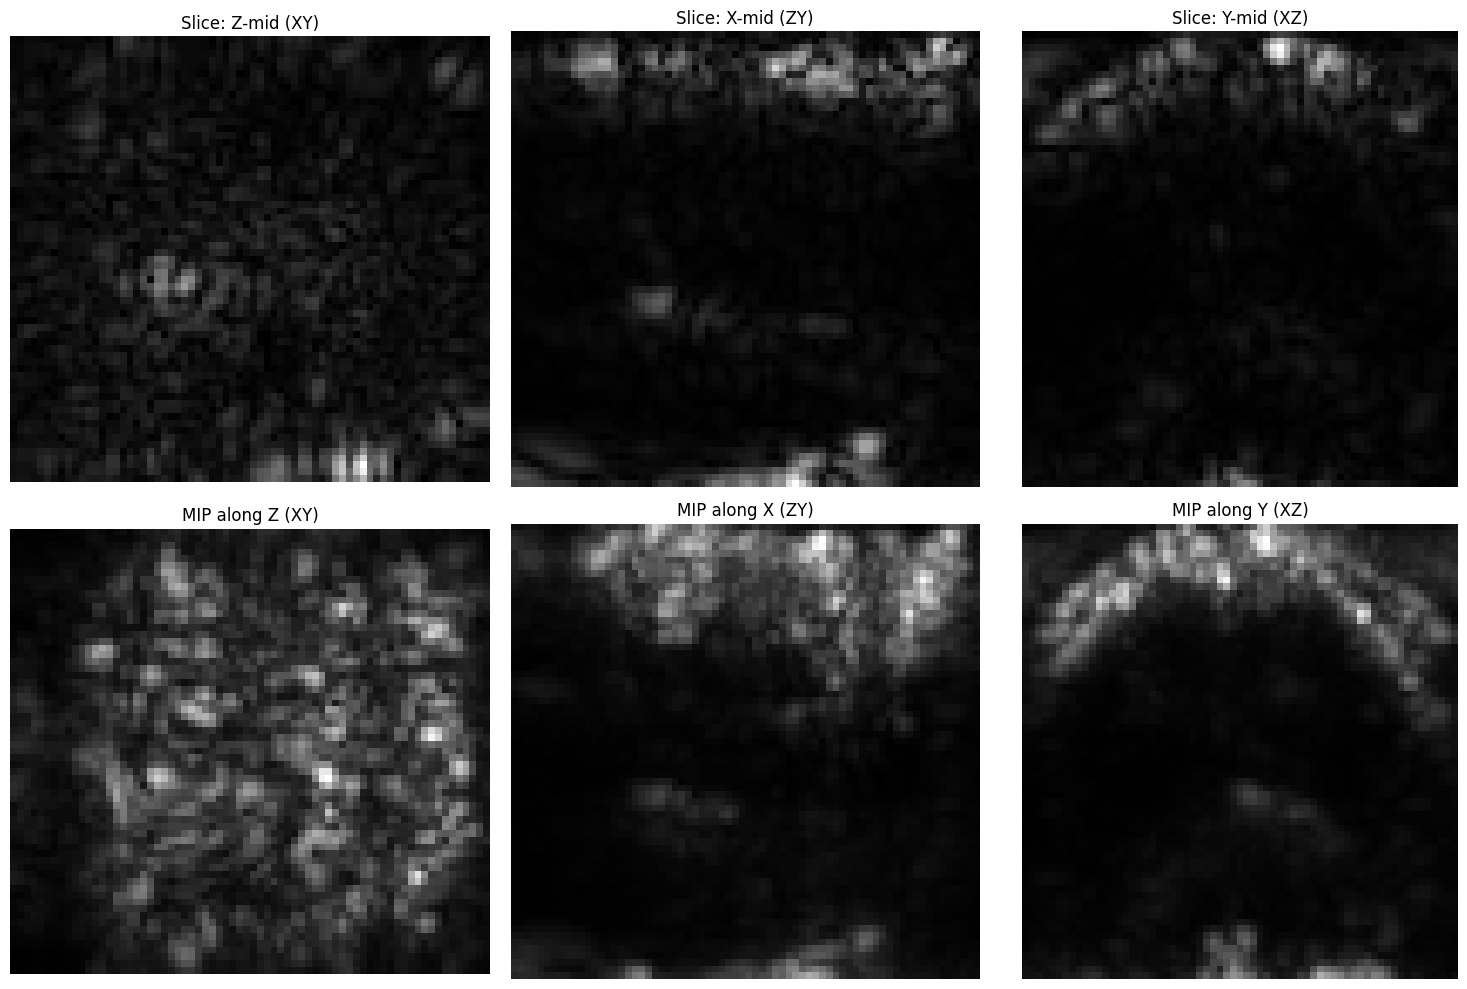

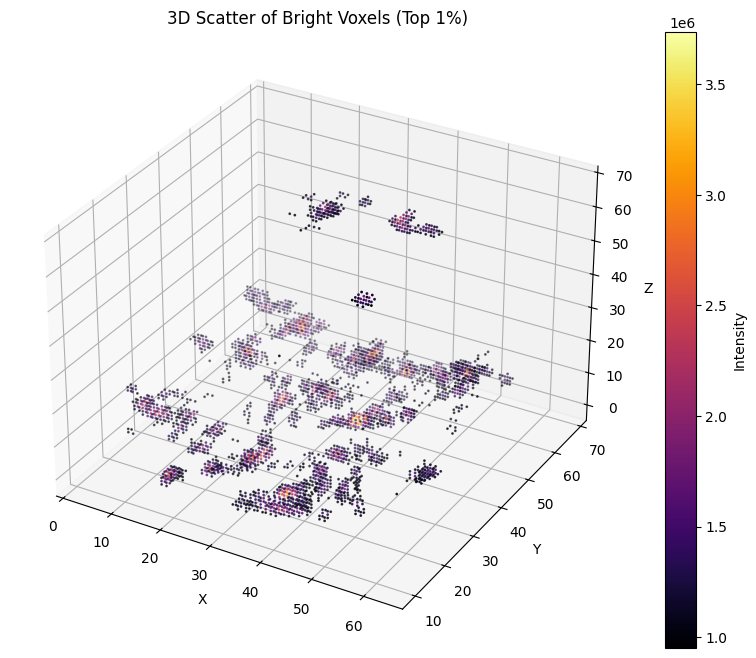

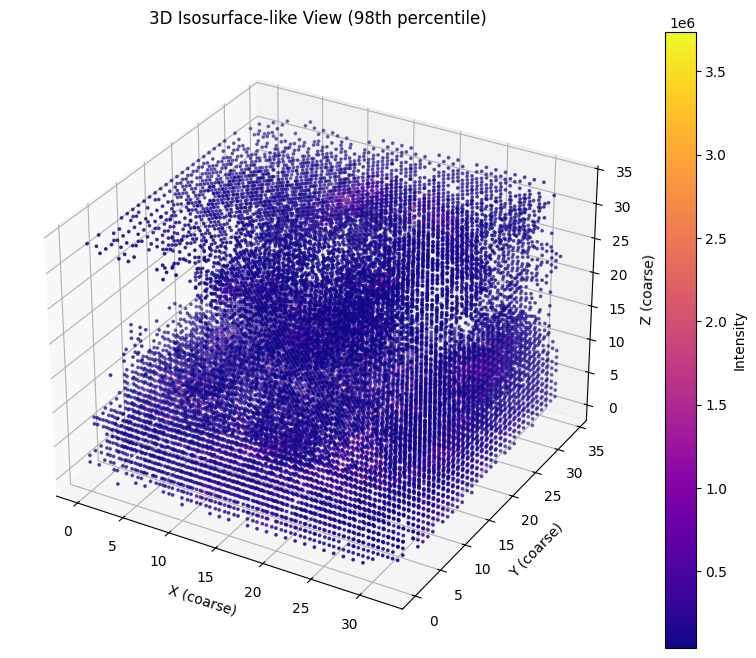

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

time = 2

# Load magnitude volume for the selected time
frame = np.abs(data[:, :, :, time])   # shape = (Z, X, Y)
Z, X, Y = frame.shape

# -------------------------
# 2D SLICES
# -------------------------
slice_z = frame[Z//2, :, :]      # XY plane (middle depth)
slice_x = frame[:, X//2, :]      # ZY plane (middle lateral)
slice_y = frame[:, :, Y//2]      # ZX plane (middle elevation)

# -------------------------
# Maximum Intensity Projections
# -------------------------
mip_z = np.max(frame, axis=0)    # XY
mip_x = np.max(frame, axis=1)    # ZY
mip_y = np.max(frame, axis=2)    # XZ

# -------------------------
# FIGURE 1: Slices + MIPs
# -------------------------
fig, axs = plt.subplots(2, 3, figsize=(15, 10))

axs[0,0].imshow(slice_z, cmap='gray')
axs[0,0].set_title("Slice: Z-mid (XY)")

axs[0,1].imshow(slice_x, cmap='gray')
axs[0,1].set_title("Slice: X-mid (ZY)")

axs[0,2].imshow(slice_y, cmap='gray')
axs[0,2].set_title("Slice: Y-mid (XZ)")

axs[1,0].imshow(mip_z, cmap='gray')
axs[1,0].set_title("MIP along Z (XY)")

axs[1,1].imshow(mip_x, cmap='gray')
axs[1,1].set_title("MIP along X (ZY)")

axs[1,2].imshow(mip_y, cmap='gray')
axs[1,2].set_title("MIP along Y (XZ)")

for ax in axs.flatten():
    ax.axis("off")

plt.tight_layout()
plt.show()

# -------------------------
# FIGURE 2: 3D Scatter (only bright voxels)
# -------------------------

# Keep top 1% brightest voxels
threshold = np.percentile(frame, 99)
mask = frame > threshold

z, x, y = np.where(mask)
values = frame[mask]

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

p = ax.scatter(
    x, y, z,
    c=values,
    s=1,
    cmap='inferno'
)

ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Z")
ax.set_title("3D Scatter of Bright Voxels (Top 1%)")

fig.colorbar(p, label="Intensity")
plt.show()

# -------------------------
# FIGURE 3: 3D Isosurface-like Plot
# -------------------------

# Create a coarse grid to avoid overload
frame_small = frame[::2, ::2, ::2]

Zs, Xs, Ys = frame_small.shape
threshold2 = np.percentile(frame_small, 50)
mask2 = frame_small > threshold2

z2, x2, y2 = np.where(mask2)
values2 = frame_small[mask2]

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

iso = ax.scatter(
    x2, y2, z2,
    c=values2,
    s=3,
    cmap='plasma'
)

ax.set_xlabel("X (coarse)")
ax.set_ylabel("Y (coarse)")
ax.set_zlabel("Z (coarse)")
ax.set_title("3D Isosurface-like View (98th percentile)")

fig.colorbar(iso, label="Intensity")
plt.show()
